# Introduction 

Hi, I’m **Aman**, a Master’s student in Life Science Informatics. This is my deep learning project, where I am implementing a Convolutional Neural Network (CNN) using Keras to identify cells infected by malaria.

The dataset for training and evaluation is publicly available on Kaggle — it contains microscopic images of both parasitized and uninfected cells, enabling the model to learn distinguishing features through image classification.

This project aims to:

         **Explore the fundamentals of deep learning in biomedical image analysis.**

         **Gain hands-on experience with CNN architectures for real-world healthcare applications.**

         **Understand data preprocessing, augmentation, and model optimization to improve classification accuracy.**

Through this project, I am bridging my background in life sciences with my growing expertise in machine learning and artificial intelligence, opening pathways to more advanced research in medical diagnostics and bioinformatics.

# Modules and Utils 

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , Flatten , Dropout
from tensorflow.keras.metrics import Precision,BinaryAccuracy,Recall
from tensorflow.keras import  layers , models
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr
import os

C:\Users\Aman Yadav\AppData\Local\Temp\ipykernel_30392\536576340.py:9: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


# Loading and filtering Data from main dataset

In [3]:
data_dir = "data"
image_exts =["jpg" , "jpeg" , "png" , "bmp"]
img = cv2.imread(os.path.join(data_dir , "Parasitized" , "C100P61ThinF_IMG_20150918_144104_cell_162.png"))
img.shape

(148, 142, 3)

### Categories ('Parasitized', 'Uninfected')

In [4]:
os.listdir(data_dir)

['Parasitized', 'Uninfected']

In [5]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)
Source:   
@keras_export(
    [
        "keras.utils.image_dataset_from_directory",
        "keras.preprocessing.image_dataset_from_directory",
    ]
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    ve

**Total Images**

**Distributing the images in 32 Batches which shuffeling enabled** 

In Keras, batching images reduces memory usage by processing only a portion of the dataset at once instead of loading it entirely.(because we have more tham 2000 images).
It speeds up computation because GPUs and TPUs are optimized for handling multiple images in parallel.
Batching also stabilizes training by averaging gradients over several samples, leading to smoother and more reliable learning.
Additionally, it allows flexibility in tuning batch size, which can influence model convergence speed and generalization ability.

In [6]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 27558 files belonging to 2 classes.


In [7]:
batch[0].shape  # -> images

(32, 256, 256, 3)

In [8]:
batch[1] # -> Labels

array([1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0])




**We Must Visualize the Image to check which number in our Y array belongs to which label** 

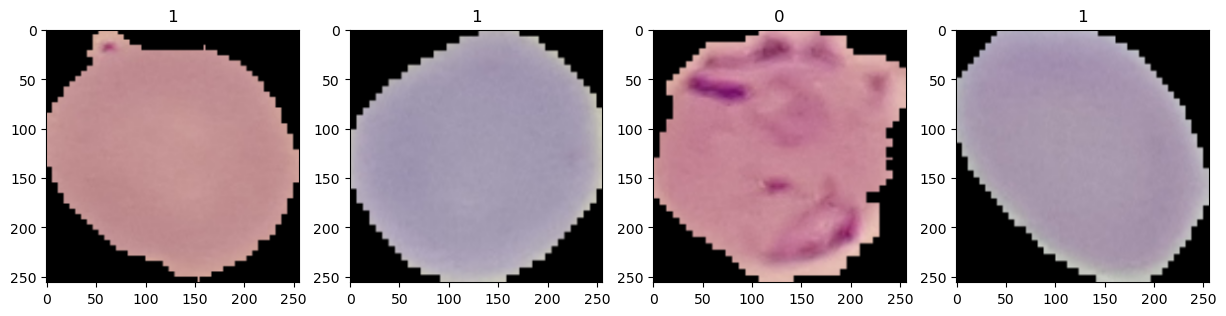

In [9]:
fig , ax = plt.subplots(ncols = 4 , figsize = (15 , 14))
for index , img in enumerate(batch[0] [:4]):
    ax[index].imshow(img.astype(int))
    ax[index].title.set_text(batch[1][index] )
#Class 0 = Infected / parasitic
#class 1 = uninfected 


# Data Preprocessing

### Normalization of our images


Normalizing images in a CNN is important because it keeps pixel values within a consistent range, which makes training more stable and faster. It prevents the model from being biased toward brighter or darker images and helps activation functions like ReLU or tanh work efficiently. Normalization also improves generalization, allowing the CNN to learn features that perform well on new, unseen data.

Here I have used map function to Normalize each Image. Notice that "y" is left as it is, Thats our labels.

In [10]:
data = data.map(lambda x , y : (x / 255 , y ))
normalized_iter = data.as_numpy_iterator()

print(f"Max Pixel Value {normalized_iter.next()[0].max()} ") #-> higest pixel
print(f"Min Pixel Value {normalized_iter.next()[0].min()} ") # ->lowest pixel



Max Pixel Value 0.929862380027771 
Min Pixel Value 0.0 


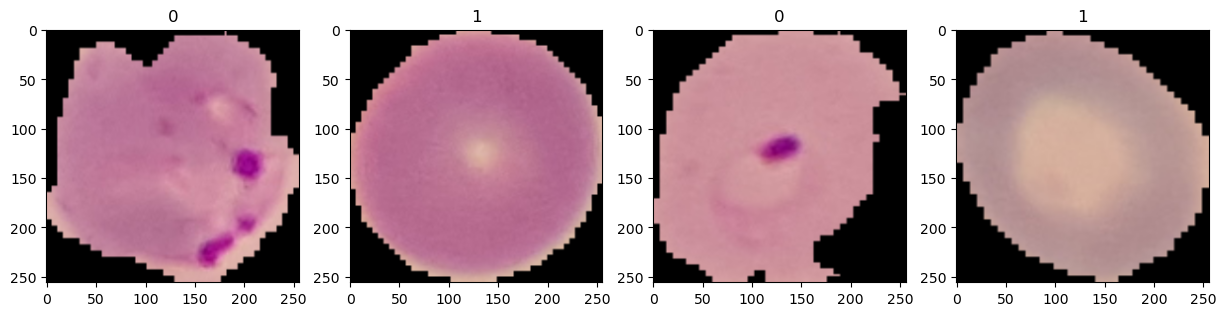

In [11]:
batch = normalized_iter.next()
fig , ax = plt.subplots(ncols = 4 , figsize = (15 , 14))
for index , img in enumerate(batch[0] [:4]):
    ax[index].imshow(img)
    ax[index].title.set_text(batch[1][index] )
#Class 0 = Infected / parasitic
#class 1 = uninfected 

In [12]:
batch[1] # -> labels

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0])

# Data Splitting

In [13]:
print(f"   Total batches {(len(data))} ") # - > total batches
print(f"   batch shape {batch[0].shape}") # - > images in in one batch and channels
total_images = len(data) * batch[0].shape[0]
print(f"   Total Images {total_images}")

   Total batches 862 
   batch shape (32, 256, 256, 3)
   Total Images 27584


**Splitting data In 70% training , 20% Val and 10% testin**g 

In [14]:
training_images = int((len(data)* 0.7))
testing_images = int((len(data)* 0.1))
validation_images = int((len(data)* 0.2))
print(training_images + testing_images +  validation_images) # total number of batches
print(training_images ,testing_images ,  validation_images )

861
603 86 172


### train test and val partition

take(n): Selects the first n elements from a dataset.

skip(n): Skips the first n elements and returns the rest.

Used together, they help slice or subset a dataset efficiently in TensorFlow.

https://www.tensorflow.org/datasets/overview

In [15]:
train = data.take(training_images)
test = data.skip(training_images).take(validation_images)
val = data.skip(validation_images + training_images).take(testing_images)

In [16]:
print(f"Training data total {len(train )}")
print(f"Testing data total {len(test)} ")
print(f"Validation data total {len(val)} ")

Training data total 603
Testing data total 172 
Validation data total 86 


# Deep Learning Model

### Training

Here I am using a Sequential CNN model where layers are stacked one after another.

The model has three convolutional layers with a kernel size of 3x3 to extract features from the input images.

Each convolutional layer is followed by a MaxPooling2D layer to reduce the spatial dimensions and keep important features.

After the convolutional layers, the Flatten layer converts the 3D feature maps into a 1D vector.

The Dense layers process these features to learn complex patterns and make predictions.

The final layer uses a sigmoid activation to output a probability for binary classification (infected vs. healthy cells).

In [17]:
cnn = models.Sequential([
    #cnn
    #conv layer 1 
        layers.Conv2D(filters = 32 , kernel_size= (3,3)  , activation= 'relu' , input_shape=(256 ,256 ,3)),
        layers.MaxPooling2D((2,2)),
    #conv layer 2

        layers.Conv2D(filters = 32, kernel_size= (3,3)  , activation= 'relu' ),
        layers.MaxPooling2D((2,2)),
    #conv layer 3

        layers.Conv2D(filters = 16, kernel_size= (3,3)  , activation= 'relu' ),
        layers.MaxPooling2D((2,2)),
    
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid' )    
    ])



C:\Users\Aman Yadav\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
cnn.compile(optimizer='adam', 
            loss='binary_crossentropy',
            metrics=['accuracy'])
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,701,681 (14.12 MB)

 Trainable params: 3,701,681 (14.12 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
hist = cnn.fit(train, epochs=3 , validation_data= val)


Epoch 1/3
603/603 ━━━━━━━━━━━━━━━━━━━━ 325s 539ms/step - accuracy: 0.9287 - loss: 0.1993 - val_accuracy: 0.9448 - val_loss: 0.1784
Epoch 2/3
603/603 ━━━━━━━━━━━━━━━━━━━━ 267s 442ms/step - accuracy: 0.9396 - loss: 0.1746 - val_accuracy: 0.9517 - val_loss: 0.1640
Epoch 3/3
603/603 ━━━━━━━━━━━━━━━━━━━━ 268s 444ms/step - accuracy: 0.9487 - loss: 0.1516 - val_accuracy: 0.9477 - val_loss: 0.1737


In [ ]:
print(hist.history.keys())

Model is performing very well Actually 

### Model Evaluation

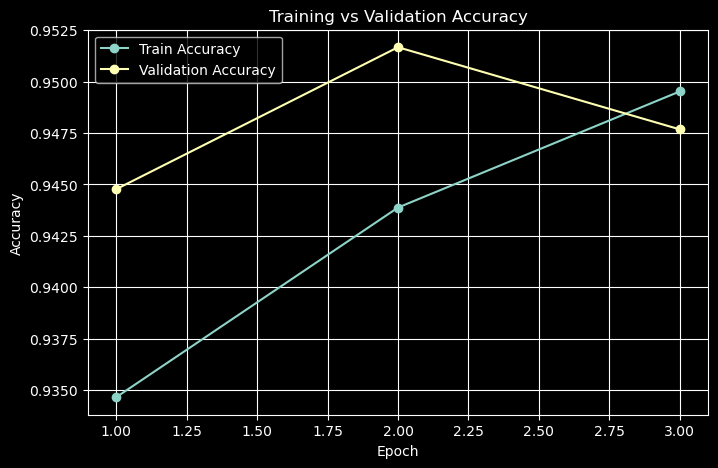

In [26]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.style.use("dark_background")


plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'o-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy')

plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

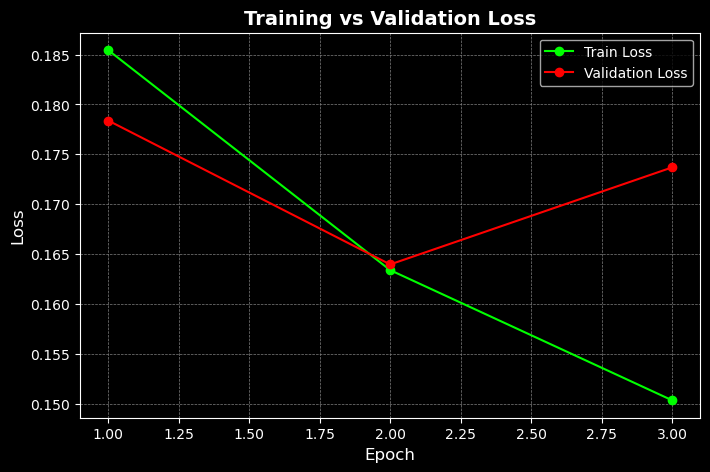

In [27]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)


plt.style.use("dark_background") # I like dark theme


plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'o-', label='Train Loss', color='lime')
plt.plot(epochs, val_loss, 'o-', label='Validation Loss', color='red')

plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.show()

In [28]:
pre = Precision()
re = Recall()
acc= BinaryAccuracy()

len(test)

172

### Predicting all 172 testing images in the batch

In [29]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yPred = cnn.predict(X)
    pre.update_state(y , yPred)
    re.update_state(y , yPred)
    acc.update_state(y , yPred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [33]:
print(f"precision {pre.result().numpy()}")
print(f"recall    {re.result().numpy()}")
print(f"accuracy  {acc.result().numpy()}")

precision 0.9380403161048889
recall    0.9503649473190308
accuracy  0.9440407156944275


### Testing

### Testing Image 1

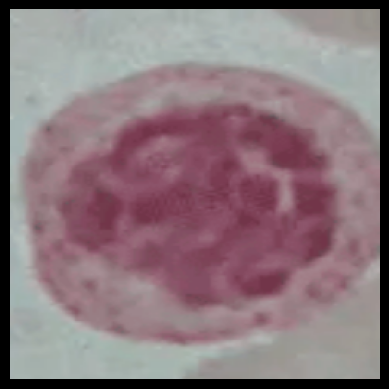

(256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.11579767]]
cell is infected 


In [34]:



img_test = cv2.imread("infected testing.png")
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

plt.imshow(img_test)
plt.axis("off")

resized = tf.image.resize(img_test, (256, 256))
plt.imshow(resized.numpy().astype("uint8"))
plt.axis("off")
plt.show()
print(resized.shape)

predictor = cnn.predict(np.expand_dims(resized /255 , 0)) # -> Normalizing the testing image (important step)
print(predictor)

if predictor > 0.5 :
    print ("Cell is not infected ")
else :
    print("cell is infected ")

### Testing Image 2

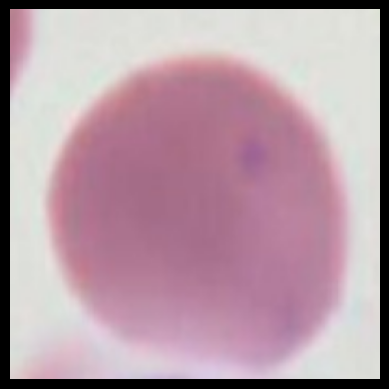

(256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[0.6253723]]
Cell is not infected 


In [35]:
img_test2 = cv2.imread("31-researchersm.jpg")
img_test2 = cv2.cvtColor(img_test2, cv2.COLOR_BGR2RGB)

plt.imshow(img_test2)
plt.axis("off")

resized2 = tf.image.resize(img_test2, (256, 256))
plt.imshow(resized2.numpy().astype("uint8"))
plt.axis("off")
plt.show()
print(resized2.shape)


predictor = cnn.predict(np.expand_dims(resized2 /255 , 0))
print(predictor)

if predictor > 0.5 :
    print ("Cell is not infected ")
else :
    print("cell is infected ")


# The trained model can now predict images of RBCs and identify whether they are infected or not.

## Uses and Benefits of the Model:

**Malaria Detection**:
        Automatically identifies RBCs infected by the malaria parasite.

**Faster Diagnosis**:
        Reduces the time needed for manual microscopic examination of blood samples.

**High Accuracy**:
        Detects subtle signs of infection that might be missed by human observers.

**Scalable Screening**:
        Can process large volumes of blood smear images quickly, useful in hospitals and remote clinics.

**Decision Support for Clinicians**:
        Assists doctors and lab technicians by providing preliminary screening results.

**Research Applications**:
        Useful for studying malaria prevalence, treatment effectiveness, and infection trends.

**Resource Efficiency**:
        Reduces dependence on highly trained personnel for routine screening in high-risk areas.